In [101]:
### Datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Skelearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch

# from yellowbrick.cluster import silhouette_visualizer

#Regression Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro

# Descripción del problema

# Exploración de los datos

In [70]:
rod = pd.read_excel('../data/rod/simulation_results.xlsx')
rod.head()

,ID,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow
0,0,3.5,15.3333,1190,76.752,31.966865,152.279497
1,1,3.5,7.6667,653,189.540,17.530478,93.460428
2,2,3.5,7.6667,653,58.729,16.312640,81.364855
3,3,3.5,7.6667,1016,76.752,26.121132,129.525084
4,4,3.5,15.3333,1016,189.540,22.906330,127.163212


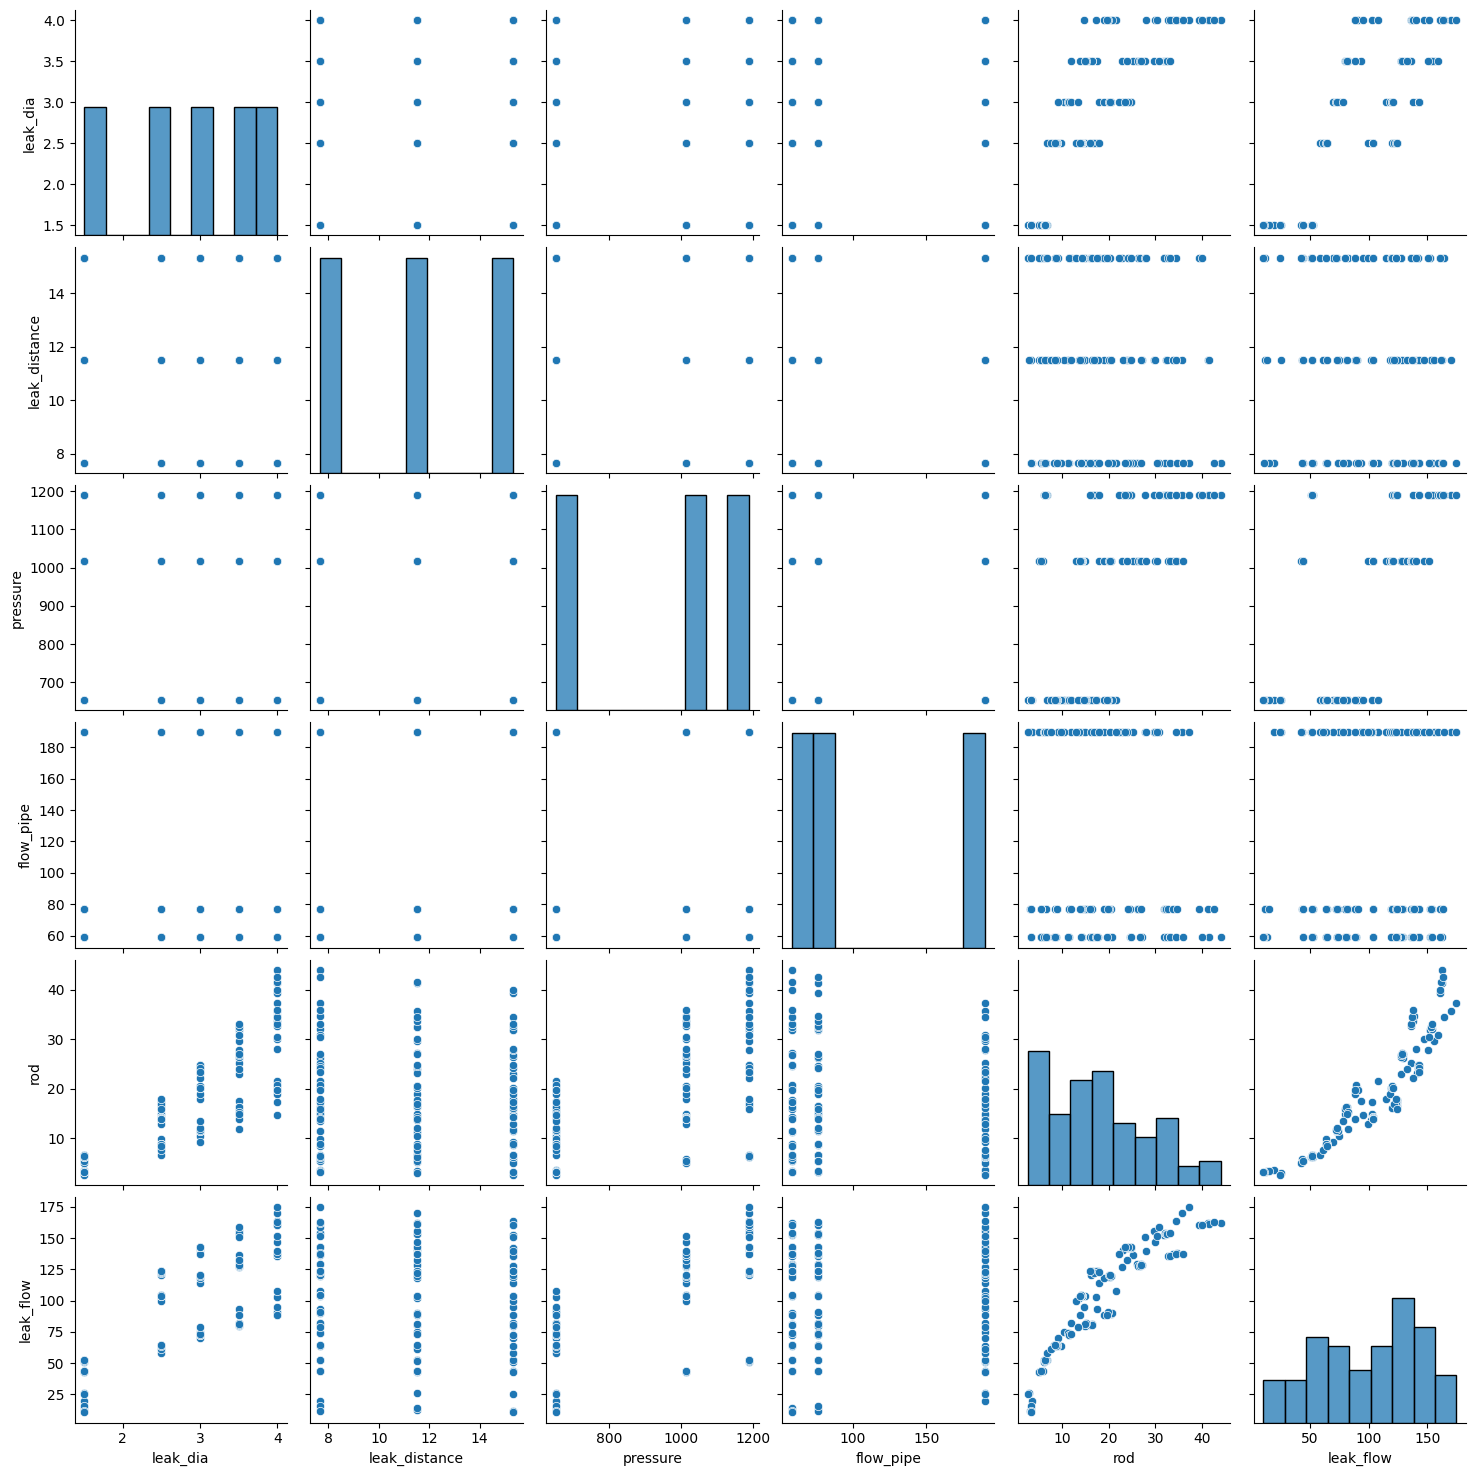

In [71]:
sns.pairplot(rod.drop(columns=["ID"]))

Debido a que las variables rod y leak_flow son resultados de las otras, solo se evaluara el problema para hallar el ROD apropiado para la combinaciónd de variables

In [72]:
#rod.drop(columns=['ID','leak_flow'], inplace=True)
#rod_f = rod.drop(columns=['ID','rod'])
rod_rod = rod.drop(columns=['ID','leak_flow'])
rod.drop(columns=['ID'], inplace=True)
rod_nor = preprocessing.scale(rod_rod)

Text(0.5, 0, 'Número de clusters')

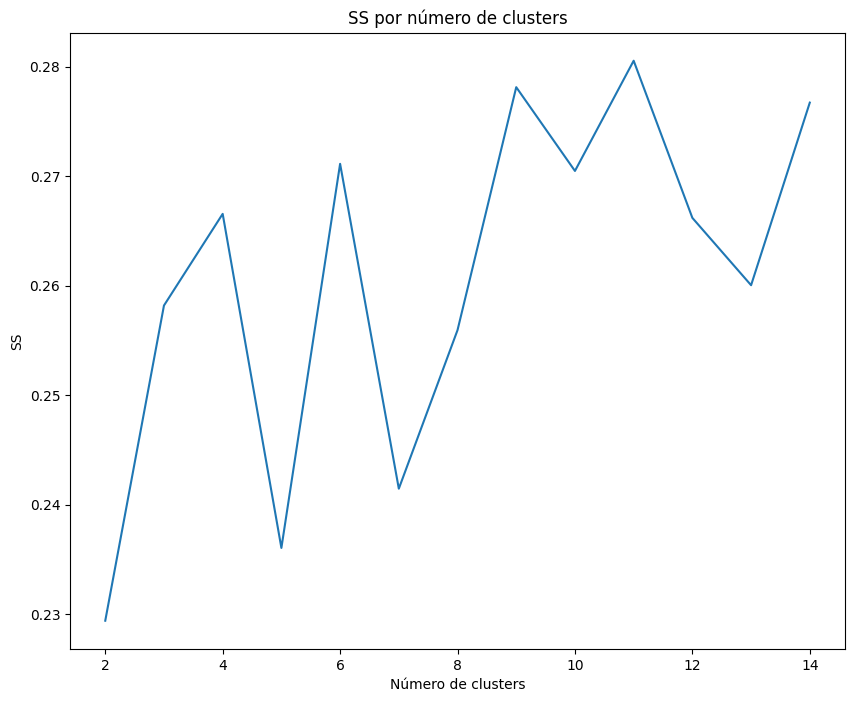

In [73]:
plt.figure(figsize=(10,8))
ss =[]
maxRange = 15
for i in range(2,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rod_nor)
  ss.append(silhouette_score(rod_nor, kmeans.labels_))
plt.plot(range(2,maxRange), ss)
plt.title('SS por número de clusters')
plt.ylabel('SS')
plt.xlabel('Número de clusters')

In [74]:
#Escojo un modelo de 2 cluster por tener el mayor ss
kmeans = KMeans(n_clusters=9, init='k-means++')
model = kmeans.fit(rod_nor)

#Guardo los clusters en el rdb recodificado
rod['Cluster'] = model.labels_

In [75]:
rod.groupby(['Cluster']).describe()['pressure']

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,12.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
1,20.0,1103.000000,89.260117,1016.0,1016.0,1103.0,1190.0,1190.0
2,11.0,1095.090909,90.868536,1016.0,1016.0,1016.0,1190.0,1190.0
3,22.0,1095.090909,88.678611,1016.0,1016.0,1016.0,1190.0,1190.0
4,18.0,1112.666667,88.967939,1016.0,1016.0,1190.0,1190.0,1190.0
5,18.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
6,15.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
7,13.0,1109.692308,90.284167,1016.0,1016.0,1190.0,1190.0,1190.0
8,6.0,1103.000000,95.303725,1016.0,1016.0,1103.0,1190.0,1190.0


<Axes: >

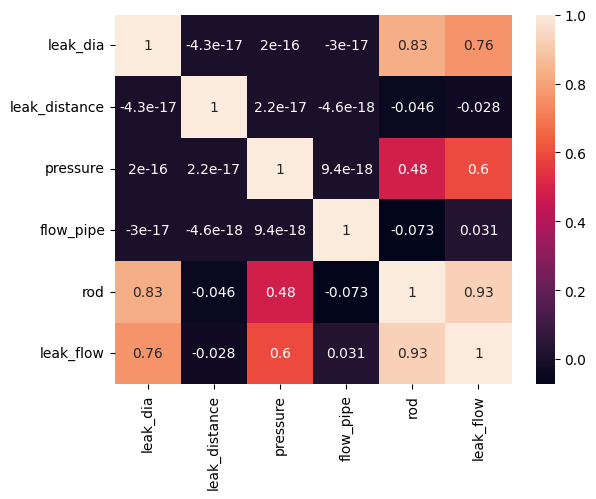

In [76]:
sns.heatmap(rod.drop(columns=['Cluster']).corr(), annot=True)

<Axes: >

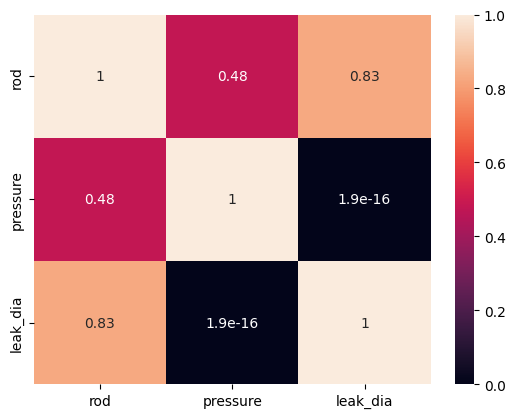

In [77]:
sns.heatmap(rod[["rod","pressure","leak_dia"]].corr(), annot=True)

In [78]:
#rod.groupby(['Cluster']).describe()['flow_pipe']

In [79]:
#px.scatter(rod,y='rod', x='pressure', color='Cluster', hover_data='leak_distance')

In [80]:
#px.scatter(rod,y='rod', x='Cluster', color='Cluster', hover_data='leak_distance')

In [81]:
#rod[rod['Cluster'] == 0]

In [82]:
X, y = rod_rod.drop(columns=["rod"]), rod_rod["rod"] 
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [83]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)

# Modelos

Utilizando GridSearch se evaluaran los siguientes modelos para escoger el que obtenga mejor performance en la data de entrenamiento usando Cross validation k folds:

- Regresión lineal
- Arboles de regresión
- Random forest de regresión

In [84]:

# Definir los modelos
models = {
    'LinearRegression': LinearRegression(),
    'PolynomialRegression': Pipeline([
        ('poly', PolynomialFeatures()),
        ('linear', LinearRegression(fit_intercept=True))
    ]),
    'RandomForestRegressor': RandomForestRegressor()

}

# Definir los parámetros a ajustar para cada modelo
params = {
    'LinearRegression': {},
    'PolynomialRegression': {
        'poly__degree': [2,3,4,5,6,7,8,9]
    },
    'RandomForestRegressor': {
        'n_estimators': [100,200,500],
    }

}

# Se evalúa cada modelo utilizando Grid Search
grid_results = []
best_models = {}
for name, model in models.items():
    #Estimators have a scor method providing a default evaluation criterion for the problem they are designed to solve
    #grid_search = GridSearchCV(model, params[name], cv=5, scoring=['accuracy', 'f1', 'recall'], refit = 'f1') 
    grid_search = GridSearchCV(model, params[name], cv=5) 
    grid_search.fit(Xtrain, ytrain)
    best_models[name] = grid_search.best_estimator_
    grid_results.append({"name": name ,"hyperparameters":grid_search.best_params_, "score": grid_search.best_score_ , "model": grid_search.best_estimator_ })

best_model_report = pd.DataFrame(grid_results).sort_values(by="score", ascending=False)
best_model_report

,name,hyperparameters,score,model
1,PolynomialRegression,{'poly__degree': 3},0.993528,"(PolynomialFeatures(degree=3), LinearRegressio..."
2,RandomForestRegressor,{'n_estimators': 500},0.979095,"(DecisionTreeRegressor(max_features=1.0, rando..."
0,LinearRegression,{},0.909099,LinearRegression()


In [85]:
best_model = max(grid_results, key= lambda x: x['score'])
best_model = best_model['model']
best_model

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())])

## BEST MODEL TRAINING PERFORMANCE

In [86]:
best_model.fit(Xtrain, ytrain)
best_model.score(Xtrain,ytrain)
result = pd.DataFrame({
  'ytrain': ytrain,
  'ypredict': best_model.predict(Xtrain)
})
result['resid'] = result['ypredict'] - result['ytrain']


### VARIANZA RESIDUOS

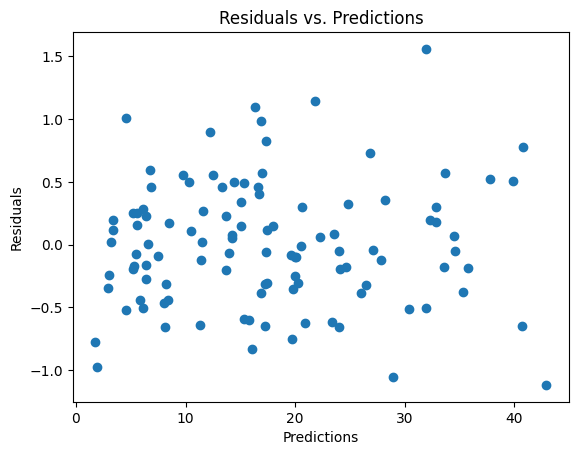

In [87]:
# VARIANZA:
plt.scatter(result['ypredict'], result['resid'])
plt.title('Residuals vs. Predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

In [88]:
# Añade una columna constante a Xtrain
Xtrain_with_constant = add_constant(Xtrain)

# Realiza la prueba de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(result['resid'], Xtrain_with_constant)
print(f'p-value for Breusch-Pagan test: {p_value}')
if p_value <= 0.05:
    print("Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).")

p-value for Breusch-Pagan test: 0.03020999619401889
Hay evidencia de heterocedasticidad (varianza no constante).


### NORMALIDAD DE LOS RESIDUOS

<Axes: xlabel='resid', ylabel='Count'>

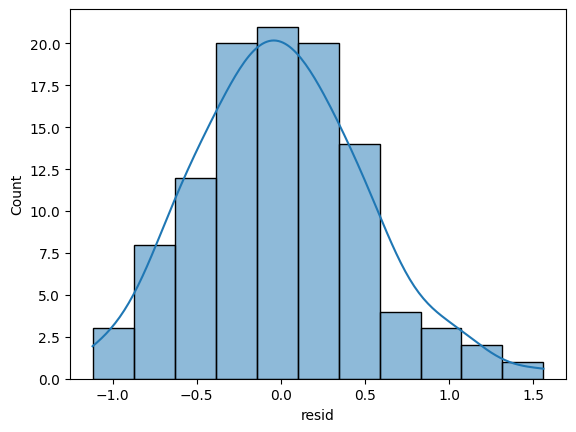

In [89]:
sns.histplot(result["resid"], kde=True)

Estadístico: 0.9906, p-valor: 0.6593
Los residuos siguen una distribución normal.


<Figure size 800x600 with 0 Axes>

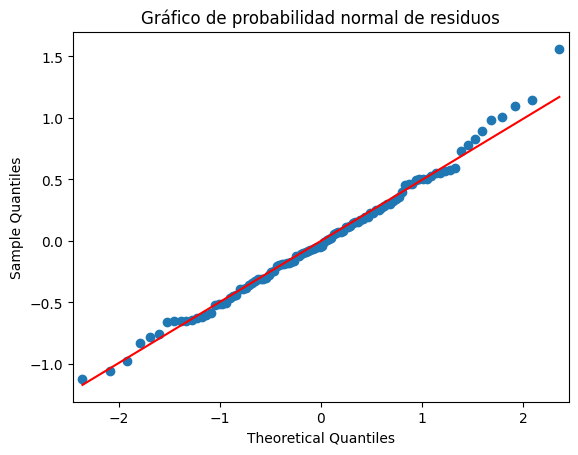

In [90]:
stat, p_val = shapiro(result["resid"])
print(f'Estadístico: {stat:.4f}, p-valor: {p_val:.4f}')
if p_val < 0.05:
    print('Los residuos no siguen una distribución normal.')
else:
    print('Los residuos siguen una distribución normal.')

plt.figure(figsize=(8, 6))
sm.qqplot(result["resid"], line='s')
plt.title('Gráfico de probabilidad normal de residuos')
plt.show()

### INDEPENDENCIA EN LOS RESIDUOS

In [91]:
# Realiza la prueba de Durbin-Watson
durbin_watson_statistic = sm.stats.stattools.durbin_watson(result['resid'])

print(f'Durbin-Watson statistic: {durbin_watson_statistic}')

# Interpreta el resultado
if durbin_watson_statistic >= 1.5 and durbin_watson_statistic <= 2.5 :
    print('Residuales aleatorios, independientes')
else:
    print('Residuales no aleatorios, dependientes.')

Durbin-Watson statistic: 2.1284769394392025
Residuales aleatorios, independientes


## BEST MODEL TEST PERFORMANCE

In [104]:
result = pd.DataFrame({
  'ytrain': ytest,
  'ypredict': best_model.predict(Xtest)
})
result['resid'] = result['ypredict'] - result['ytrain']

In [105]:
best_model.score(Xtest, ytest)
result

,ytrain,ypredict,resid
124,14.361671,14.269618,-0.092053
88,18.999514,19.088826,0.089312
100,19.783897,21.178352,1.394454
105,42.635636,41.524844,-1.110791
4,22.906330,22.831996,-0.074334
119,8.787098,7.861500,-0.925597
74,5.446510,5.115027,-0.331483
99,34.512408,34.727158,0.214750
112,14.894760,14.855664,-0.039096
0,31.966865,31.607412,-0.359454


### VARIANZA RESIDUOS

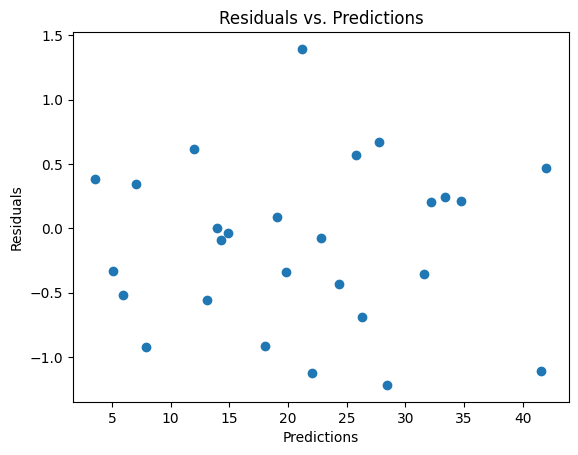

In [93]:
# VARIANZA:
plt.scatter(result['ypredict'], result['resid'])
plt.title('Residuals vs. Predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

In [94]:
# Añade una columna constante a Xtrain
Xtrain_with_constant = add_constant(Xtest)

# Realiza la prueba de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(result['resid'], Xtrain_with_constant)
print(f'p-value for Breusch-Pagan test: {p_value}')
if p_value <= 0.05:
    print("Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).")

p-value for Breusch-Pagan test: 0.10523543995826498
No hay suficiente evidencia para sugerir heterocedasticidad (varianza constante).


### NORMALIDAD DE LOS RESIDUOS

<Axes: xlabel='resid', ylabel='Count'>

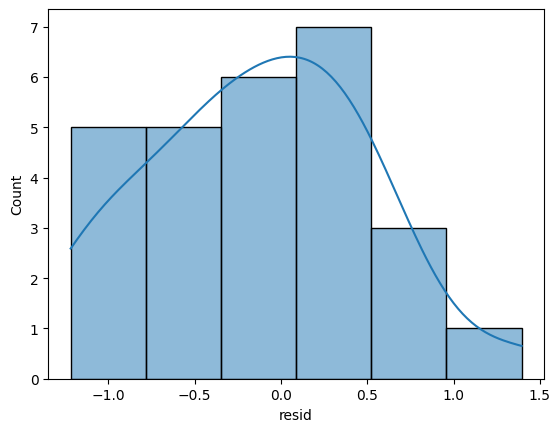

In [95]:
sns.histplot(result["resid"], kde=True)

Estadístico: 0.9754, p-valor: 0.7459
Los residuos siguen una distribución normal.


<Figure size 800x600 with 0 Axes>

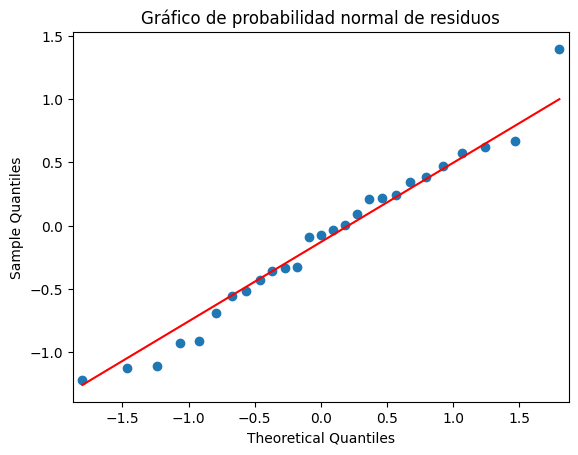

In [96]:
stat, p_val = shapiro(result["resid"])
print(f'Estadístico: {stat:.4f}, p-valor: {p_val:.4f}')
if p_val < 0.05:
    print('Los residuos no siguen una distribución normal.')
else:
    print('Los residuos siguen una distribución normal.')

plt.figure(figsize=(8, 6))
sm.qqplot(result["resid"], line='s')
plt.title('Gráfico de probabilidad normal de residuos')
plt.show()

### INDEPENDENCIA EN LOS RESIDUOS

In [97]:
# Realiza la prueba de Durbin-Watson
durbin_watson_statistic = sm.stats.stattools.durbin_watson(result['resid'])

print(f'Durbin-Watson statistic: {durbin_watson_statistic}')

# Interpreta el resultado
if durbin_watson_statistic >= 1.5 and durbin_watson_statistic <= 2.5 :
    print('Residuales aleatorios, independientes')
else:
    print('Residuales no aleatorios, dependientes.')

Durbin-Watson statistic: 2.116970660503345
Residuales aleatorios, independientes


## BEST MODEL SCORE WITH NEW DATA

In [100]:
#Probando el modelo con datos que nunca ha visto y no hacían parte del Xtrain
test_results = pd.read_excel('../data/rod/test_results.xlsx')
X, y = test_results.drop(columns=["rod", 'leak_flow']), test_results["rod"] 
predict = best_model.predict(X)
result = pd.DataFrame({
  'y' : y,
  'y2' : predict
})
best_model.score(X,y)

0.9911671991565567

# REGRESIÓN - ROD VS LEAK_FLOW

In [113]:
rod_Y = rod['rod']
rod_X = rod['leak_flow']
X = rod_X.values.reshape(-1, 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, rod_Y, test_size=0.2, random_state=123)

In [114]:
lineal = LinearRegression()
model = lineal.fit(Xtrain, ytrain)
model.score(Xtrain,ytrain)

0.8610513845845572

In [115]:
model.score(Xtest,ytest)

0.842777082659656

In [120]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),    ('linear', LinearRegression(fit_intercept=False))])
model.fit(Xtrain, ytrain)
model.score(Xtrain, ytrain)
model.score(Xtest, ytest)

0.8979692723316605